STEP BY STEP OF NEST SIMULATION
1) IMPORTING RELEVANT DATA FROM SNUDDA GENERATED NEURON FILES:\
    a. Neuron Matrix: to keep the info of neuron types \
    b. Synaptic Matrix: Where each row has the info of [preID, posID] of one synapse \
    for now every synapse will have the same properties, no matter the types of neurons\
    (later we can add more info on this matrix that will help set the type of synapses used for each)\
    c*. (optional/not really relevant but already available) Positions: matrix with coordinates for each neuron position\
    d.Info about the input given to the neurons
2) CREATING THE NEST NETWORK \
    a. Create the neurons (the correct # of neurons, in their posiiton*)\
    b. Connect the neurons (for loop with Synaptic Matrix as info)\
    c. Connect the measuring devices to the neurons in order to observe spiking and voltage \
    d. Feed the input\
3) RUN THE SIM
    

In [1]:
import nest
from getData import *
from plot import *

In [2]:
positions_list = getNeuronPositions('/home/ubuntu/BasalGanglia/NEURON-data/net_100/network-neuron-positions.hdf5')

In [3]:
pos = nest.spatial.free(positions_list) # using NEURON positions

s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) #create all the neurons at once, with same characteristics
#needs to be upgraded to a function, that will change neuron specifications according to type 
#(once this is done changes in the connection protocol will be needed (bc they wont all be in one pop))


In [4]:
############################## THIS FUNCTION WILL BE HELD ON THE .PY FILE   #################################
#def getSynapses(path):
    
with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/network-pruned-synapses.hdf5', 'r') as file:
    synapses = file.get('network').get('synapses')

    synaptic_matrix = []
    for i in range(0,len(synapses)):
        synaptic_matrix.append([synapses[i][0], synapses[i][1]]) #Pre_ID | Pos_ID

#    return(synaptic_matrix)  
#####################################

for i in range(0,len(synaptic_matrix)):
    nest.Connect(s_nodes[synaptic_matrix[i][0]],s_nodes[synaptic_matrix[i][1]])
    


In [30]:
import numpy as np
import h5py

with h5py.File('/home/ubuntu/BasalGanglia/NEURON-data/net_100/input-spikes.hdf5', 'r') as file:
    
    size = 3
    inputs = file.get('input')
    final_input = []
    
    for i in range(0, size):
        a = str(i)
        aux_input = []
        
        cortical_base = np.array(inputs.get(a).get("CorticalBase").get('spikes'))
        cortical_signal = np.array(inputs.get(a).get("CorticalSignal").get('spikes'))
        thalamic = np.array(inputs.get(a).get("Thalamic").get('spikes'))
        
        for line in cortical_base:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)

        for line in cortical_signal:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)
                    
        for line in thalamic:
            for spike_time in line:
                if (spike_time!=-1):
                    aux_input.append(spike_time*1000)
        
        aux_input.sort()
        final_input.append(np.around(aux_input, decimals = 2))
print(final_input[0])

[   4.63   18.48   20.5    22.8    34.65   39.47   40.93   40.95   41.4
   41.67   44.94   47.04   54.22   58.53   59.62   62.45   62.48   64.74
   68.37   71.36   72.78   75.61   76.36   85.65   86.45   87.15   91.89
   95.8    99.13  108.33  113.2   120.01  122.36  126.76  133.41  144.05
  144.58  144.64  150.28  156.99  160.25  162.88  163.81  166.93  172.35
  181.67  183.38  184.14  186.67  203.41  205.07  206.89  209.01  209.15
  209.36  213.41  215.99  219.69  233.72  241.27  244.07  244.6   247.71
  249.13  252.49  256.13  257.52  262.37  269.02  271.41  278.79  288.16
  299.16  310.51  311.59  314.32  318.42  325.8   327.77  330.86  339.15
  339.25  341.04  350.79  352.07  356.27  359.86  361.39  365.3   370.28
  370.8   371.76  372.59  380.36  388.15  390.33  391.12  392.65  392.98
  395.24  397.77  412.74  413.06  417.86  428.49  430.73  446.6   450.96
  458.02  458.76  459.59  463.11  466.01  466.53  470.54  471.84  472.88
  475.18  476.85  478.07  482.11  482.52  487.91  49

In [25]:
input_0 = nest.Create("spike_generator", params={"spike_times": final_input[0]})

/home/ubuntu/nest-build/lib/python3.8/site-packages/nest/lib/hl_api_nodes.py:134: UserWarning:SetStatus() call failed, but nodes have already been created! The node IDs of the new nodes are: NodeCollection(metadata=None, model=spike_generator, size=1, first=100).


NESTErrors.BadProperty: BadProperty in SLI function SetStatus_id: Setting status of a 'spike_generator' with node ID 100: spike_generator: Time point 4.62627 is not representable in current resolution.

697


In [17]:
# THIS WAS A SECOND IDEA ON HOW TO CONNECT THE NETWORK BUT -> to loop the array creation but not the nest connect command 
# so it doesnt get too heavy. so far it is not working.

pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes['global_id' == synaptic_matrix[i][0]])
    pos_list.append(s_nodes['global_id' == synaptic_matrix[i][1]])

    

nest.Connect(pre_list,pos_list,conn_spec= "one_to_one")


ValueError: Sources and targets must be 1-dimensional arrays

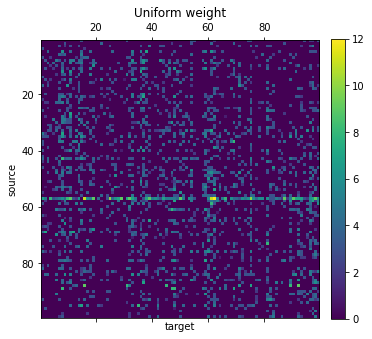

In [14]:
##### HOW TO ENSURE THAT THE INFORMATION WAS PROPERLY INSERTED? THAT IS, THAT THE CONNECTIONS ARE EQUAL TO THE NEST ONES######
# NO NEED TO PROVE THIS. BUT THIS CONN MATRIX, IF I MANAGE TO ORDER NEURONS BY THEIR TYPE, CAN PROVIDE INSIGHTS NONETHELESS
conns = nest.GetConnections(s_nodes, s_nodes)  # This returns a SynapseCollection
# We can get desired information of the SynapseCollection with simple get() call.
g = conns.get(['source', 'target', 'weight'])
srcs = g['source']
tgts = g['target']
weights = g['weight']

# Plot the matrix consisting of the weights between the sources and targets
plt.figure(figsize=(12, 10))
plotMatrix(srcs, tgts, weights, 'Uniform weight', 121)

In [19]:
help(nest.Models)

Help on function Models in module nest.lib.hl_api_models:

Models(mtype='all', sel=None)
    Return a tuple of model names, sorted by name.
    
    All available models are neurons, devices and synapses.
    
    Parameters
    ----------
    mtype : str, optional
        Use ``'mtype='nodes'`` to only see neuron and device models,
        or ``'type='synapses'`` to only see synapse models.
    sel : str, optional
        String used to filter the result list and only return models
        containing it.
    
    Returns
    -------
    tuple
        Available model names
    
    Raises
    ------
    ValueError
        Description
    
    Notes
    -----
    - Synapse model names ending with ``'_hpc'`` provide minimal memory
      requirements by using thread-local target neuron IDs and fixing
      the ``'rport'`` to 0.
    - Synapse model names ending with ``'_lbl'`` allow to assign an individual
      integer label (``'synapse_label'``) to created synapses at the cost
      of i